### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/CI2020-hackathon/James/'

Mounted at /gdrive
/gdrive/My Drive/CI2020-hackathon/James


In [ ]:
device='gpu' # 'tpu'/'gpu'

In [ ]:
if device=='gpu':
  gpu_info = !nvidia-smi
  print('\n'.join(gpu_info))
  device='cuda'

Tue Sep 29 11:22:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data

In [2]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import pandas as pd
import torch
import time
import pandas as pd
import os

In [ ]:
CloudTop = np.load("../public_data/X_train_CI20.npy")
TrueColor = np.load("../public_data/Y_train_CI20.npy")
TrueColor.shape, CloudTop.shape

((8423, 127, 127, 3), (8423, 127, 127, 3))

## Exploratory Data Analysis

### Preprocessing

In [ ]:
mask = np.where(np.sum(TrueColor,axis=(1,2,3))>0.)
TrueColorNZ = TrueColor[mask]
CloudTopNZ = CloudTop[mask]

In [ ]:
darkness_intensity = 5

# fraction of pixels which are dark per image
val = (TrueColorNZ.sum(axis=3)<darkness_intensity).mean(axis=(1,2))

In [ ]:
# keep images with at most this fraction dark
cutoff = 0.02
keep = val<cutoff
print(f"Removed {sum(~keep)} entries out of {len(TrueColorNZ)}")

# Find darkest images kept
indexes = np.arange(len(TrueColorNZ))
keep_indexes = np.array([y[1] for y in sorted(enumerate(indexes[keep]), key=lambda x: val[keep][x[0]], reverse=True)])
discard_indexes = np.array([y[1] for y in sorted(enumerate(indexes[~keep]), key=lambda x: val[~keep][x[0]], reverse=False)])

N=10
max_per_row = 5

print(f'Below are the most dark images kept with cutoff fraction {cutoff}. Dark regions shown with contour.')

plt.figure(figsize=(20,8))
for i, index in enumerate(keep_indexes[:N]):
  plt.subplot((N-1)//max_per_row+1, max_per_row, i+1)
  plt.imshow(array_to_img(TrueColorNZ[index,:,:,:]))
  plt.contour(array_to_img(TrueColorNZ[index,:,:,:].sum(axis=2, keepdims=True)<darkness_intensity), levels=[0,1], colors='white', alpha=0.5)
plt.show()

print(f'Below are the least dark images discarded with cutoff fraction {cutoff}. Dark regions shown with contour.')
plt.figure(figsize=(20,8))
for i, index in enumerate(discard_indexes[:N]):
  plt.subplot((N-1)//max_per_row+1, max_per_row, i+1)
  plt.imshow(array_to_img(TrueColorNZ[index,:,:,:]))
  plt.contour(array_to_img(TrueColorNZ[index,:,:,:].sum(axis=2, keepdims=True)<darkness_intensity), levels=[0,1], colors='white', alpha=0.5)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
TrueColorFiltered = TrueColorNZ[keep]
CloudTopFiltered  = CloudTopNZ[keep]

# Set dark pixels to NaN so we don't learn these
TrueColorFiltered[TrueColorFiltered.sum(axis=3)<darkness_intensity] = np.nan

In [ ]:
np.isnan(TrueColorFiltered).mean()

0.0005591149887715891

In [ ]:
TrueColorFiltered.shape, CloudTopFiltered.shape

((3785, 127, 127, 3), (3785, 127, 127, 3))

In [ ]:
del CloudTop, TrueColor

# U-Net++

In [ ]:
from lib.unet_plus import NestedUNet
from lib.ssim import SSIM

calc_ssim = SSIM(filter_nan=True, channel=3)
loss_fn = lambda x1, x2: -calc_ssim(x1,x2)

In [ ]:
model = NestedUNet(num_classes=3, input_channels=3, deep_supervision=True, nb_filter=[8, 16, 32, 64, 128]).to(device)
optim = torch.optim.Adam(model.parameters())

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
       BatchNorm2d-2          [-1, 8, 128, 128]              16
              ReLU-3          [-1, 8, 128, 128]               0
            Conv2d-4          [-1, 8, 128, 128]             584
       BatchNorm2d-5          [-1, 8, 128, 128]              16
              ReLU-6          [-1, 8, 128, 128]               0
          VGGBlock-7          [-1, 8, 128, 128]               0
         MaxPool2d-8            [-1, 8, 64, 64]               0
            Conv2d-9           [-1, 16, 64, 64]           1,168
      BatchNorm2d-10           [-1, 16, 64, 64]              32
             ReLU-11           [-1, 16, 64, 64]               0
           Conv2d-12           [-1, 16, 64, 64]           2,320
      BatchNorm2d-13           [-1, 16, 64, 64]              32
             ReLU-14           [-1, 16,

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

def pad(data):
  return F.pad(input=data, pad=(0, 1, 0, 1), mode='constant', value=0)

In [ ]:
batch_size = 10
test_size=500

tensor_x = pad(torch.from_numpy(CloudTopFiltered.transpose((0,3,1,2))/255))
tensor_y = torch.from_numpy(TrueColorFiltered.transpose((0,3,1,2))/255.)

dataset = TensorDataset(tensor_x,tensor_y)

# split into train and test sets and create dataloader
train_set, test_set = torch.utils.data.random_split(dataset, (len(dataset)-test_size, test_size), generator=torch.Generator().manual_seed(42))
dataloader = DataLoader(train_set, batch_size=batch_size)

test_X, test_y = test_set[:]
test_X = test_X.to(device)
test_y = test_y.to(device)

del tensor_x, tensor_y, train_set, test_set, dataset, CloudTopNZ, TrueColorNZ

In [ ]:
STATS_PERIOD = 50
MODEL_DUMP_ROOT="output_dump"
mode='fast'

N=50

class net_container:
    def __init__(self, net, optimizer, loss_func, test_X, test_y, run_name=None):
        self.net = net
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.run_name = run_name
        self.test_X = test_X
        self.test_y = test_y
        
        self.running_train_loss = 0
        self.train_losses = []
        self.test_losses = []
        self.batch = []
        self.time_elapsed = []
        
    
    def train_step(self, X, y, batch_number):
        


        # forward + backward + optimize
        self.net.train()
        
        outputs = [op[:,:,:-1, :-1] for op in self.net(X)]
        train_loss = sum([self.loss_func(op, y) for op in outputs])/len(outputs)

        self.running_train_loss += train_loss.item()
        
        train_loss.backward()
        self.optimizer.step()

        # zero the parameter gradients
        self.optimizer.zero_grad()

        del outputs, train_loss

        # print statistics
        if batch_number == 0 or batch_number % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches

            # Train loss
            if batch_number == 0:
                mean_train_loss = self.running_train_loss
                self.t0 = time.time()
            else:
                mean_train_loss = self.running_train_loss / STATS_PERIOD

            self.train_losses.append(mean_train_loss)
            
            self.running_train_loss = 0.

            # Test loss
            self.net.eval()
            
            test_loss=0
            for i in range((self.test_X.shape[0]-1)//N + 1):
              test_outputs = [op[:,:,:-1, :-1] for op in self.net(self.test_X[i*N:(i+1)*N])]
              if mode=='fast':
                test_outputs = test_outputs[-1]
              else:
                test_outputs = sum(test_outputs)/len(test_outputs)
              l = self.loss_func(test_outputs, self.test_y[i*N:(i+1)*N]).item()
              l = l * min(N, self.test_X.shape[0]-i*N)/self.test_X.shape[0]
              test_loss += l

            self.test_losses.append(test_loss)
           
            self.batch.append(batch_number)
            self.time_elapsed.append(time.time() - self.t0)

            print(f"batch {batch_number} | {self.time_elapsed[-1]}s elapsed | train_loss {mean_train_loss:.5f} | test_loss {self.test_losses[-1]:.5f}"+" "*10, flush=True)
            
            if self.run_name:
                thisdir = os.path.join(MODEL_DUMP_ROOT, self.run_name)
                if batch_number==0:
                    
                    os.system(f"rm -rf {thisdir}")
                    os.makedirs(thisdir)
                    
                              
                df = pd.DataFrame({
                    'time_elapsed':self.time_elapsed,
                    'batch':self.batch,
                    'train_loss':self.train_losses,
                    'test_loss':self.test_losses,
                }).to_csv(os.path.join(thisdir, 'training_stats.csv'))
                
                if test_loss == min(self.test_losses):
                    torch.save(self.net, os.path.join(thisdir, 'best_model.pkl'))

In [ ]:
wrapped_model = net_container(model, optim, loss_fn, test_X, test_y, run_name='unet_filt_ds')

# batch number
bn = 0

In [ ]:
batch_epochs=[(10, 60), (32, 30), (64, 30), (128, 20), (256, 20)]

for batch_size, epochs in batch_epochs:

  print(f"transition to (batch:{batch_size}, epochs: {epochs})")
  dataloader = DataLoader(dataloader.dataset, batch_size=batch_size)

  for _ in range(epochs):
      
      for X, y in dataloader:
          X = X.to(device)
          y = y.to(device)
          wrapped_model.train_step(X,y,bn)
          bn+=1

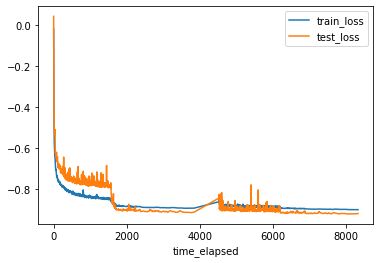

In [3]:
df = pd.read_csv('output_dump/unet_filt_ds/training_stats.csv')
df = df[df.train_loss>-1]
df.plot(x='time_elapsed', y=['train_loss', 'test_loss'])

In [4]:
df.test_loss.min()

-0.9208903551101684

In [ ]:
model = torch.load('output_dump/unet_filt_ds/best_model.pkl')
model.eval();

In [ ]:
# Calculate scores for test set images
scores = []
for i in range(len(test_X)):
             scores += [loss_fn(model(test_X[i:i+1])[-1][:,:, :-1, :-1], test_y[i:i+1]).item()]

In [ ]:
# Sort indexes of test set images by score
indexes = [x[0] for x in sorted([(i,s) for i,s in enumerate(scores)], key=lambda x: x[1], reverse=True)]

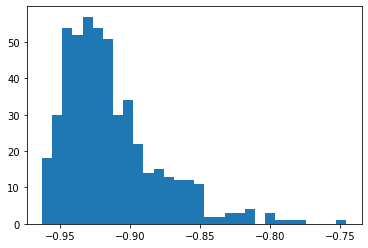

In [ ]:
# Distribution of test set scores
plt.hist(scores, bins=30)
plt.show()

In [ ]:
np.median(scores)

-0.9214144349098206

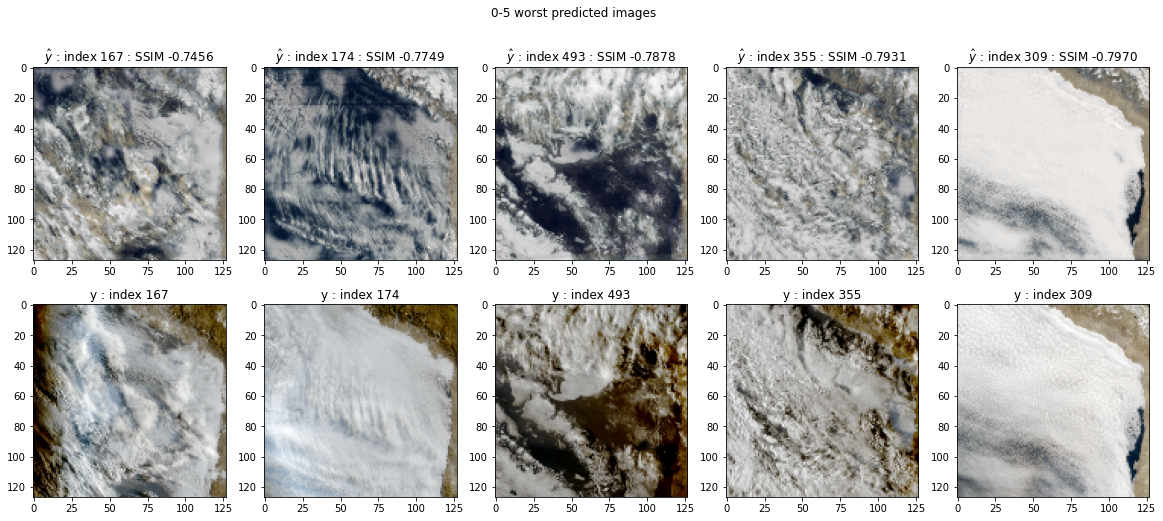

In [ ]:
# Plot preidctions and ground truth of worst scoring test set images

def post_process(imgs):
  return imgs.detach().cpu().numpy().transpose((0,2,3,1))*255

# start at this index
ind=0
# plot this many images
n=5

# Make predictions for worst scoring test set images
img_x = test_X[indexes[ind:ind+n]]
img_y_hat = post_process(model(img_x)[0][:,:, :-1, :-1])
img_y = post_process(test_y[indexes[ind:ind+n]])
img_y[np.isnan(img_y)]=0

plt.figure(figsize=(20,8))
plt.suptitle(f'{ind}-{ind+n} worst predicted images')

for i, index in enumerate(indexes[ind:ind+n]):
  plt.subplot(2,n,i+1)
  plt.imshow(array_to_img(img_y_hat[i]))
  plt.title('$\hat{y}$'+f' : index {index} : SSIM {scores[index]:.4f}')

  plt.subplot(2,n,i+1+n)
  plt.imshow(array_to_img(img_y[i]))
  plt.title(f'y : index {index}')

plt.show()

In [ ]:
X_test = np.load("../public_data/NightVision.npy")

X_test = pad(torch.from_numpy(X_test.transpose((0,3,1,2))/255)).to(device)

predictions = model(X_test).detach().cpu().numpy()[:,:,:-1,:-1].transpose((0,2,3,1))*255

In [ ]:
predictions_file = "predictions"

def save_compress(predictions, name):
    np.save(f'{predictions_file}/{name}.npy', predictions)
    os.system(f"mv {predictions_file}/{name}.npy {predictions_file}/{name}.predict")
    os.system(f"zip -jrm {predictions_file}/{name}.zip {predictions_file}/{name}.predict")
    os.system(f"rm {predictions_file}/{name}.predict")

save_compress(predictions5, 'Y_NightVision_stargazer')